# LightGBM with KFold

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

データの前処理

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [3]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
def create_numeric(input_df):

    use_cols = [
        'Pclass',
        'Age',
        'SibSp',
        'Parch'
    ]

    return input_df[use_cols].copy()

def create_one_hot_encoding(input_df):

    use_columns = [
        'Sex',
        'Embarked'
    ]

    out_df = pd.DataFrame()
    for column in use_columns:

        vc = df_train[column].value_counts()
        cat = pd.Categorical(input_df[column], categories=vc.index)
        out_i = pd.get_dummies(cat)
        out_i.columns = out_i.columns.tolist()
        out_i = out_i.add_prefix(f'{column}=')
        out_df = pd.concat([out_df, out_i], axis=1)
    return out_df

from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric,
        create_one_hot_encoding
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [5]:
df_train_feature = to_feature(df_train)
df_test_feature = to_feature(df_test)

100%|██████████| 2/2 [00:00<00:00, 286.78it/s]


## Classification

In [6]:
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

def fit_lgbm(X,
             y,
             cv,
             params: dict=None,
             verbose: int=500):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)

        clf.fit(x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                early_stopping_rounds=100,
                verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} ROC-AUC: {roc_auc_score(y_valid, pred_i) ** .5:.4f}')

    score = roc_auc_score(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole ROC-AUC: {:.4f}'.format(score))
    return oof_pred, models

In [7]:
params = {
    'objective': 'binary',
    'boosting': 'gbdt',
    'metric': 'binary_logloss',

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .1,

    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1
    'reg_alpha': .1,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5,

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 10000,

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5,

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック
    'importance_type': 'gain',
    'random_state': 71,
}

In [8]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
y = df_train['Survived']
cv = list(fold.split(df_train_feature, y))

oof, models = fit_lgbm(df_train_feature.values, y, cv, params=params, verbose=500)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.37857
Fold 0 ROC-AUC: 0.9012
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.445607
Fold 1 ROC-AUC: 0.8977
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.428572
Fold 2 ROC-AUC: 0.8988
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
Early stopping, best iterat

In [9]:
def visualize_importance(models, df_train_feature):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = df_train_feature.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df,
                  x='feature_importance',
                  y='column',
                  order=order,
                  ax=ax,
                  palette='viridis',
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

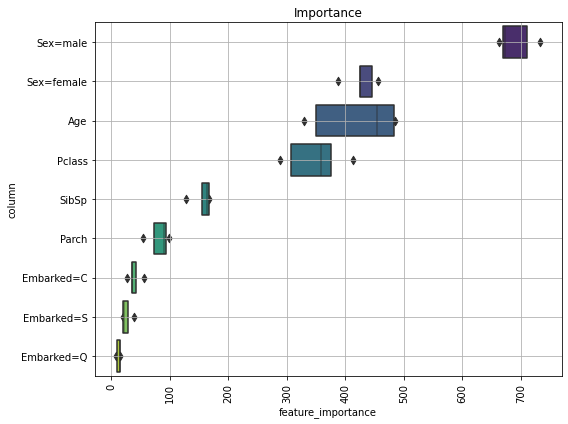

In [10]:
fig, ax = visualize_importance(models, df_train_feature)

## Regression

In [11]:
from sklearn.datasets import fetch_california_housing

In [12]:
data = fetch_california_housing()
df = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']

In [13]:
from sklearn.model_selection import train_test_split
df_train, df_test, y_train, y_test  = train_test_split(df, y, train_size=0.7, random_state=0)
len(df_train), len(df_test), len(y_train), len(y_test)

(14447, 6193, 14447, 6193)

In [14]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X,
             y,
             cv,
             params: dict=None,
             verbose: int=500):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)

        clf.fit(x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                early_stopping_rounds=100,
                verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSE: {:.4f}'.format(score))
    return oof_pred, models

In [15]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します.
    'objective': 'rmse',

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .1,

    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1
    'reg_alpha': .1,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5,

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 10000,

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5,

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain',
    'random_state': 71,
}

In [16]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(df_train, y_train)) # もともとが generator なため明示的に list に変換する

oof, models = fit_lgbm(df_train.values, y_train, cv, params=params, verbose=500)

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.463818
[1000]	valid_0's rmse: 0.46033
Early stopping, best iteration is:
[984]	valid_0's rmse: 0.459897
Fold 0 RMSE: 0.4599
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.438333
Early stopping, best iteration is:
[584]	valid_0's rmse: 0.437437
Fold 1 RMSE: 0.4374
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[373]	valid_0's rmse: 0.46471
Fold 2 RMSE: 0.4647
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.500634
Early stopping, best iteration is:
[498]	valid_0's rmse: 0.500504
Fold 3 RMSE: 0.5005
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.449492
Early stopping, best iteration is:
[552]	valid_0's rmse: 0.449004
Fold 4 RMSE: 0.4490
--------------------------------------------------
FINISHED | Whole RMSE: 0.4628


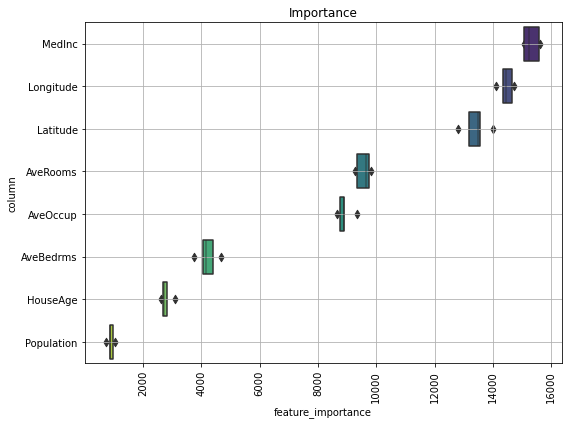

In [17]:
fig, ax = visualize_importance(models, df_train)

In [18]:
pred = np.array([model.predict(df_test.values) for model in models])
pred = np.mean(pred, axis=0)

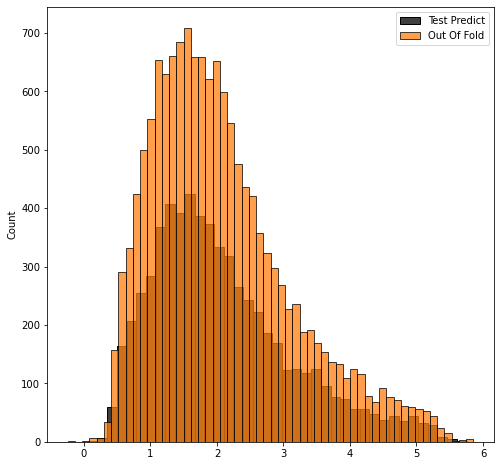

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(pred, label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend();